[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool which NVIDIA recently ported to GPUs with a python interface.  In this notebook we will demostrate basic usage, plotting, and timing comparisons between the CUDA (GPU) version of UMAP and the original CPU version of UMAP 

In [1]:
print('^#0')
!pip install umap-learn

^#0


In [2]:
print('^#1')
!pip install seaborn
!pip install matplotlib


^#1


In [3]:
print('^#2')
!nvidia-smi

^#2
Mon Oct 18 23:13:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:15:00.0 Off |                  Off |
| 29%   43C    P2    27W / 250W |   1646MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GV100        Off  | 00000000:2D:00.0 Off |                  Off |
| 34

In [4]:
print('^#3')
import os
import pandas as pd
import numpy as np

# CPU UMAP
import umap

# libraries for scoring/clustering
from sklearn.manifold import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

^#3


We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.

In [5]:
print('^#4')
if not os.path.exists('fashion_mnist'):
    !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

^#4


In [6]:
print('^#5')
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

^#5


In [7]:
print('^#6')
train, train_labels = load_mnist('fashion_mnist/data/fashion', kind='train')
test, test_labels = load_mnist('fashion_mnist/data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

^#6


There are 60000 training images and 10000 test images

In [8]:
print('^#7')
f"Train shape: {train.shape} and Test Shape: {test.shape}"

^#7


'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [9]:
print('^#8')
train[0].shape

^#8


(784,)

As mentioned previously, each row in the train matrix is an image

^#9


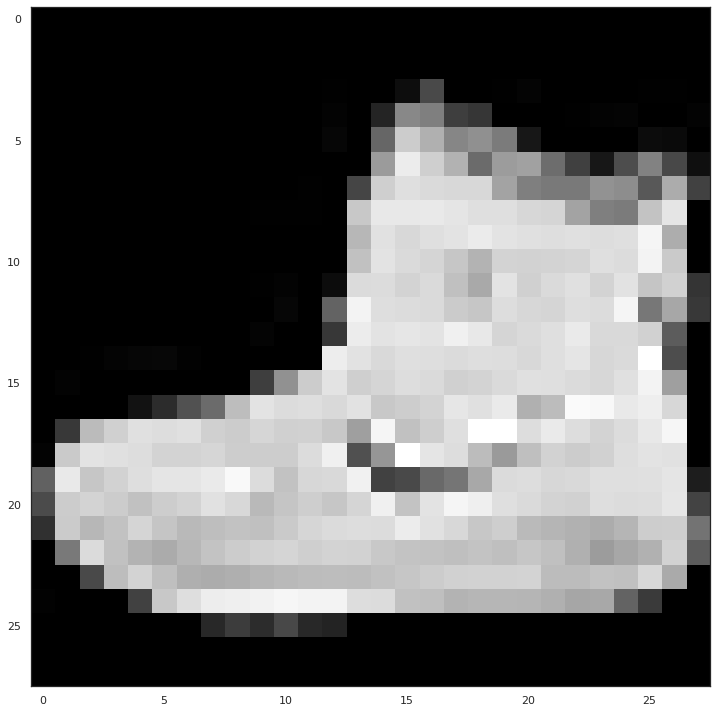

In [10]:
print('^#9')
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [11]:
%%time
print('^#10')
gdf = cudf.DataFrame()
for i in range(data.shape[1]):
    gdf['fea%d'%i] = data[:,i]

^#10
CPU times: user 1.72 s, sys: 572 ms, total: 2.29 s
Wall time: 2.32 s


In [12]:
%%timeit
print('^#11')
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

^#11


CUDADriverError: CUDA_ERROR_UNSUPPORTED_PTX_VERSION: the provided PTX was compiled with an unsupported toolchain.

`gdf` is a GPU backed dataframe -- all the data is stored in the device memory of the GPU.  With the data converted, we can apply the `cumlUMAP` the same inputs as we do for the standard UMAP.  Additionally, it should be noted that within cuml, [FAISS] https://github.com/facebookresearch/faiss) is used for extremely fast kNN and it's limited to single precision.  `cumlUMAP` will automatically downcast to `float32` when needed.

In [ ]:
%%timeit
print('^#12')
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)

Compute Runtimes of UMAP training (lower is better):
- cumlUMAP (GPU): 10.5
- UMAP (CPU): 100 seconds

cumlMAP is ~9.5x speed up over UMAP CPU.  We should also qualitatively compare output accuracy.  We can do this easily by plotting the embeddings and noting simlarites in the plot

In [ ]:
print('^#13')
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [ ]:
print('^#14')
#Needs to be redone because of timeit loses our variables sometimes
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

Just as the original author of UMAP, Leland McInnes, states in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation between the various classes defined above.

In [ ]:
print('^#15')
g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

And side-by-side we can see that the separation is very similar between both GPU and CPU versions of UMAP.  Both cluster Ankle Boot, Sneaker, and Sandal together (Green/Yellow/Purple), both separate Trousers and Bags entirely, and both have T-shirts, Shirts, Coats, etc. all mixed toether.

In [ ]:
print('^#16')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(embedding[:,1], embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Fashion MNIST Embedded via cumlUMAP');
ax[1].set_title('Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
 print('^#END')


Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py#L395).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `embedding/g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention.  As [Corey Nolet](https://github.com/cjnolet) notes:
> Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation and the training time was ~9.5X faster